In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from typing import Literal

import ipywidgets as widgets
from ipywidgets import GridBox, Button
from IPython.display import display, clear_output

import os
import ast
from datetime import datetime

### Read progress and records files

In [79]:
environments = {
    "water_tank": {
        "base_dir": "../logs/TD3_DDPG/double_water_tank/trainings",
        "tracked_point": "x2",
    },
    "CPAP": {
        "base_dir": "../logs/TD3_DDPG/CPAP/trainings",
        # "base_dir": "../logs/TD3_DDPG/CPAP/optuna_trainings_PID_only",
        "tracked_point": "x3",
    },
}

env_name: Literal["water_tank", "CPAP"] = "water_tank"
env = environments[env_name]
base_dir = env["base_dir"]
tracked_point = env["tracked_point"]

folder_names = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]
def folder_to_datetime(folder_name):
    """
    Função para converter o nome da pasta em um objeto datetime.
    Combinada com max(), é possível ordenar de forma decrescente pastas por data da mais recente (max) para antiga (min).
    O nome da pasta DEVE estar no formato '%d-%m-%H%M' ou ter uma substring nesse formato para funcionar corretamente.
    """
    pattern = r'\d{2}-\d{2}-\d{4}'
    match = re.search(pattern, folder_name)
    if match:
        date_str = match.group(0)
        date_str = datetime.strptime(date_str, '%d-%m-%H%M')
        return (date_str.month, date_str.day)
    else:
        raise ValueError(f"Formato de data inválido na pasta: {folder_name}")


folder_names.sort(key=folder_to_datetime)

latest_folder = folder_names[-1] # max(folder_names, key=folder_to_datetime)
selected_folder = latest_folder
selected_index = len(folder_names) - 1


# print(folder_names)
# print(f"A pasta mais recente é: {latest_folder}")

In [80]:
def are_required_files_present(folder: str):
    return all([
        # os.path.exists(f"{base_dir}/{folder}/returns.csv"),
        # os.path.exists(f"{base_dir}/{folder}/progress.csv"),
        os.path.exists(f"{base_dir}/{folder}/records.csv"),
        # os.path.exists(f"{base_dir}/{folder}/only_pid_records.csv"),
    ])

In [81]:
def load_dfs(folder: str) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:

    if not are_required_files_present(folder):
        raise FileNotFoundError(f"Arquivos necessários não encontrados no caminho {folder}.")
    
    returns_df = pd.read_csv(f"{base_dir}/{folder}/returns.csv")
    rec_df = pd.read_csv(f"{base_dir}/{folder}/records.csv")

    # Find the index of the last episode start
    mask = rec_df["steps_in_episode"] == 1
    start_episode_indexes = mask[mask].index.to_list()
    last_episode_start_idx = start_episode_indexes[-1]

    # Filter the dataframe for the last episode
    last_episode_df = rec_df.loc[last_episode_start_idx:]

    return returns_df, rec_df, last_episode_df

returns_df, rec_df, last_episode_df = load_dfs(latest_folder)

In [82]:
returns_df

,return_per_episode
0,-2099.415312
1,-1280.775990
2,-815.306517
3,-929.954560
4,-5355.009635
...,...
95,-6892.662583
96,-11751.523904
97,-7503.680929
98,-12934.473944


In [83]:
rec_df

,x1,x2,y_ref,z_t,PID_action,agent_action,combined_action,reward,error,steps_in_episode
0,0.000000,7.925338,5.0,-2.925338,-31.337792,[-28.508556],-28.508556,-8.557601,-2.925338,1
1,0.000000,7.337851,5.0,-5.263189,-25.809393,[-24.38648],-24.386480,-5.465548,-2.337851,2
2,0.000000,6.772559,5.0,-7.035748,-20.675690,[-20.089775],-20.089775,-3.141964,-1.772559,3
3,0.000000,6.229476,5.0,-8.265224,-15.728812,[-15.271419],-15.271419,-1.511613,-1.229477,4
4,0.000000,5.708624,5.0,-8.973848,-10.969244,[-10.979455],-10.979455,-0.502148,-0.708624,5
...,...,...,...,...,...,...,...,...,...,...
199995,8.426564,5.047306,3.0,-25.000000,-18.337638,[2.7392833],2.739283,-4.191462,-2.047306,1996
199996,8.545007,5.055345,3.0,-25.000000,-18.391599,[2.9542506],2.954251,-4.224445,-2.055346,1997
199997,8.583014,5.066396,3.0,-25.000000,-18.462443,[2.5763986],2.576399,-4.269991,-2.066396,1998
199998,8.484933,5.078008,3.0,-25.000000,-18.559834,[1.9143169],1.914317,-4.318117,-2.078008,1999


# Separa as linhas por episódio

In [84]:
mask = rec_df["steps_in_episode"] == 1
start_episode_indexes = mask[mask].index.to_list()

first_episode_start = start_episode_indexes[0]
first_episode_end = start_episode_indexes[1] - 1 if len(start_episode_indexes) > 1 else len(rec_df) - 1

last_episode_start = start_episode_indexes[-1]
last_episode_end = len(rec_df) - 1

first_episode = rec_df.iloc[first_episode_start:first_episode_end+1]
last_episode = rec_df.iloc[last_episode_start:last_episode_end+1]

episodes_count = len(start_episode_indexes)

In [85]:
first_episode

,x1,x2,y_ref,z_t,PID_action,agent_action,combined_action,reward,error,steps_in_episode
0,0.000000,7.925338,5.0,-2.925338,-31.337792,[-28.508556],-28.508556,-8.557601,-2.925338,1
1,0.000000,7.337851,5.0,-5.263189,-25.809393,[-24.38648],-24.386480,-5.465548,-2.337851,2
2,0.000000,6.772559,5.0,-7.035748,-20.675690,[-20.089775],-20.089775,-3.141964,-1.772559,3
3,0.000000,6.229476,5.0,-8.265224,-15.728812,[-15.271419],-15.271419,-1.511613,-1.229477,4
4,0.000000,5.708624,5.0,-8.973848,-10.969244,[-10.979455],-10.979455,-0.502148,-0.708624,5
...,...,...,...,...,...,...,...,...,...,...
1995,3.976415,2.490206,3.0,-17.101112,3.938288,[3.1513681],3.151368,-0.259890,0.509794,1996
1996,4.571536,2.485425,3.0,-16.586538,4.231300,[3.2110887],3.211089,-0.264788,0.514575,1997
1997,5.268631,2.504398,3.0,-16.090937,4.279704,[3.6489782],3.648978,-0.245621,0.495602,1998
1998,5.917432,2.547708,3.0,-15.638643,4.118982,[3.569706],3.569706,-0.204568,0.452292,1999


In [86]:
# first_episode.plot(x="steps_in_episode", y="combined_action", title="Primeiro Episódio")

In [87]:
# last_episode.plot(x="steps_in_episode", y="x2", title="Último Episódio")

In [88]:
# last_episode.plot(x="steps_in_episode", y="combined_action", title="Último Episódio")

### Plot Train over iteraçtion

In [89]:
# def plot_progress(folder: str, save = False):
#     # Plotting train/loss vs train/iteration
#     plt.figure(figsize=(12, 6))
#     plt.plot(progress_df['train/iteration'], progress_df['train/loss'], label='Train Loss')
#     plt.xlabel('Iteration')
#     plt.ylabel('Loss')
#     plt.title('Train Loss vs. Iteration')
#     plt.legend()
#     plt.grid(True)
#     if save:
#         plt.savefig(f"{base_dir}/{folder}/loss_over_iteration.png")
#     else: 
#         plt.show()

# plot_progress(latest_folder, save = True)

### Plote reward over steps

In [90]:
def plot_rewards(folder: str, save=False):
    # Plotting reward vs steps
    plt.figure(figsize=(12, 6))
    plt.plot(last_episode_df['steps_in_episode'], last_episode_df['reward'], label='Reward')
    plt.xlabel('Steps')
    plt.ylabel('Reward')
    plt.title('Reward vs. Steps')
    plt.legend()
    plt.grid(True)
    if save:
        plt.savefig(f"{base_dir}/{folder}/reward_over_last_episode_steps.png")
    else:
        plt.show()

# plot_rewards(latest_folder, save=True)

### Plot Set point curve

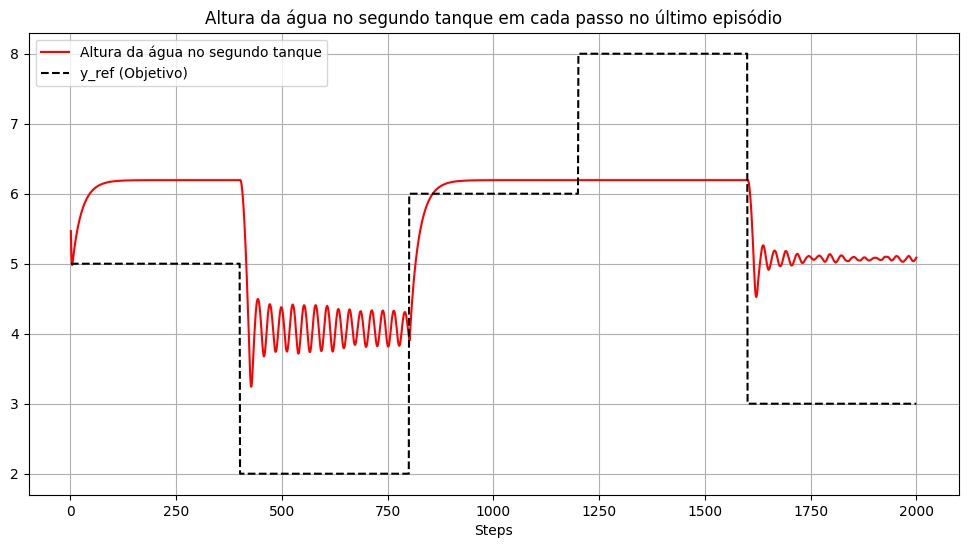

In [91]:
def plot_tracking(folder: str, save: bool = False):
    # Plot y_ref vs steps_in_episode
    plt.figure(figsize=(12, 6))
    if env_name == "water_tank":
        plt.title('Altura da água no segundo tanque em cada passo no último episódio')
        tracked_point_label = "Altura da água no segundo tanque"
    else:
        plt.title('Pressão exercida pelo CPAP')
        tracked_point_label = "Pressão"
    plt.plot(last_episode_df['steps_in_episode'], last_episode_df[tracked_point], label=tracked_point_label, color='red')
    plt.plot(last_episode_df['steps_in_episode'], last_episode_df['y_ref'], '--', label='y_ref (Objetivo)', color='black')
    plt.xlabel('Steps')
    plt.ylabel('')
    plt.legend()
    plt.grid(True)
    if save:
        plt.savefig(f"{base_dir}/{folder}/tracking.png")
    else:
        plt.show()

plot_tracking(latest_folder, save=False)

### Ação do PPO e PID durante o último episódio

In [92]:
rec_df["agent_action"].max()

'[9.999715]'

In [ ]:
def plot_action_per_steps(folder: str, save: bool = False, separated: bool = True):

    if (separated):
        # Plotting action vs steps in the last episode
        plt.figure(figsize=(12, 6))
        plt.plot(last_episode_df['steps_in_episode'], last_episode_df['PID_action'], label='PID_action', color='blue')
        plt.xlabel('Steps')
        plt.ylabel('Action')
        plt.title('Ação do controlador PID em cada passo no último episódio')
        plt.legend()
        plt.grid(True)
        if save:
            plt.savefig(f"{base_dir}/{folder}/PID_action.png")
        else:
            plt.show()

        # Plotting action vs steps in the last episode
        try:
            agent_action = last_episode_df["agent_action"].apply(lambda x: np.array(ast.literal_eval(x))).apply(lambda x: x.item())
        except Exception as e:
            agent_action = last_episode_df["agent_action"]
        plt.figure(figsize=(12, 6))
        plt.plot(last_episode_df['steps_in_episode'], agent_action, label='agent_action', color='red')
        plt.xlabel('Steps')
        plt.ylabel('Action')
        plt.title('Ação do controlador TD3_DDPG (somado com PID) em cada passo no último episódio')
        # plt.yticks(np.arange(np.floor(agent_action.min()), np.ceil(agent_action.max()) + 1, 1))
        plt.legend()
        plt.grid(True)
        if save:
            plt.savefig(f"{base_dir}/{folder}/agent_action.png")
        else:
            plt.show()
    else:
        # Plotting action vs steps in the last episode
        plt.figure(figsize=(12, 6))
        plt.plot(last_episode_df['steps_in_episode'], last_episode_df['PID_action'], label='PID_action', color='blue')
        plt.plot(last_episode_df['steps_in_episode'], last_episode_df['combined_action'], label='agent_action', color='red')
        # plt.plot(last_episode_df['steps_in_episode'], last_episode_df['action'], label='Action', color='black')
        plt.xlabel('Steps')
        plt.ylabel('Action')
        plt.title('Ação em cada passo no último episódio')
        plt.legend()
        plt.grid(True)
        if save:
            plt.savefig(f"{base_dir}/{folder}/combined_action.png")
        else:
            plt.show()

# plot_action_per_steps(latest_folder, save=False, separated=True)

In [94]:
def plot_returns_per_episode(folder: str, save: bool = False, use_std: bool = False):

    num_episodes = returns_df.__len__()
    mean_returns = returns_df.mean(axis=0).iloc[0]
    std_returns = returns_df.std(axis=0).iloc[0]

    # Plotando com banda de desvio padrão
    plt.figure(figsize=(10, 5))
    plt.plot(returns_df, label="Retorno Médio por Episódio", color="blue")
    if use_std:
        plt.fill_between(range(num_episodes), 
                         returns_df["return_per_episode"] - std_returns, 
                         returns_df["return_per_episode"] + std_returns, 
                         alpha=0.3, 
                         color="blue", 
                         label="Desvio Padrão"
                         )
    plt.xlabel("Episódio")
    plt.ylabel("Retorno")
    plt.title("Comparação de Algoritmos - Retorno por Episódio")
    plt.legend()
    plt.grid()
    if save:
        plt.savefig(f"{base_dir}/{folder}/agent_action.png")
    else:
        plt.show()

# plot_returns_per_episode(latest_folder, save=False)

# Função para exibir a grade de pastas

In [95]:
import ipywidgets as widgets
from IPython.display import display, clear_output

def display_folders_grid(folder_names: list[str], selected_indices: int = 0) -> widgets.VBox:
    num_cols = 5
    previous_selected = [selected_indices]
    
    def on_button_click(b: widgets.Button):
        global selected_folder
        selected_folder = b.description

        global progress_df, rec_df, last_episode_df
        progress_df, rec_df, last_episode_df = load_dfs(selected_folder)

        previous_selected.append(buttons.index(b))
        if len(previous_selected) > 2:
            previous_selected.pop(0)
        
        # Atualiza cor dos botões
        buttons[previous_selected[0]].button_style = '' 
        buttons[previous_selected[1]].button_style = 'success'

        clear_output(wait=True)  # Limpar as saídas anteriores
        display(grid)            # Reexibir a grade de botões
        display(save_button)     # Reexibir o botão de salvar

        plot_tracking(selected_folder, save=False)
        # plot_rewards(selected_folder, save=False)
        plot_action_per_steps(selected_folder, save=False, separated=True)
        plot_returns_per_episode(selected_folder, save=False, use_std=False)

    def on_save_click(b: widgets.Button):
        should_save = True  # Ativar o modo de salvar
        
        if 'selected_folder' in globals():
            plot_tracking(selected_folder, save=should_save)
            plot_rewards(selected_folder, save=should_save)
            plot_action_per_steps(selected_folder, save=should_save, separated=True)
            plot_action_per_steps(selected_folder, save=should_save, separated=False)
            plot_returns_per_episode(selected_folder, save=False, use_std=False)
            print(f"Plots salvos para {selected_folder}!")
        else:
            print("Nenhuma pasta selecionada ainda!")

    # Criar os botões para as pastas
    buttons = []
    for i, folder in enumerate(folder_names):
        button = widgets.Button(description=folder, layout=widgets.Layout(width='auto', height='auto'))
        button.on_click(on_button_click)
        buttons.append(button)
    
    # Marcar o primeiro botão como ativo
    buttons[selected_indices].button_style = 'success'  
    
    # Criar o botão de salvar
    save_button = widgets.Button(description="Salvar Gráficos", button_style='info')
    save_button.on_click(on_save_click)

    # Criar a grade de botões
    grid = widgets.GridBox(
        children=buttons,
        layout=widgets.Layout(grid_template_columns=f'repeat({num_cols}, 1fr)')
    )

    display(save_button)
    display(grid)
    display(save_button)


GridBox(children=(Button(description='08-03-1819', layout=Layout(height='auto', width='auto'), style=ButtonSty…

Button(button_style='info', description='Salvar Gráficos', style=ButtonStyle())

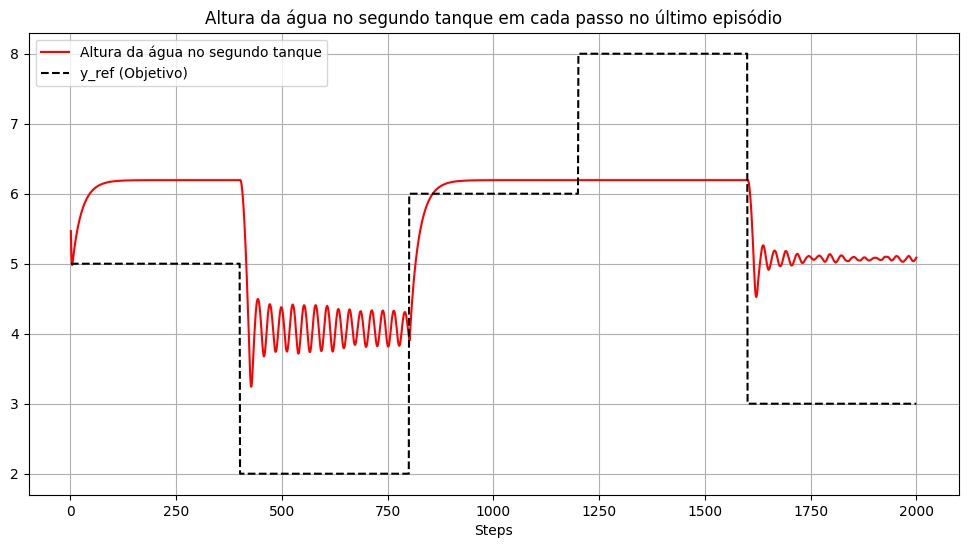

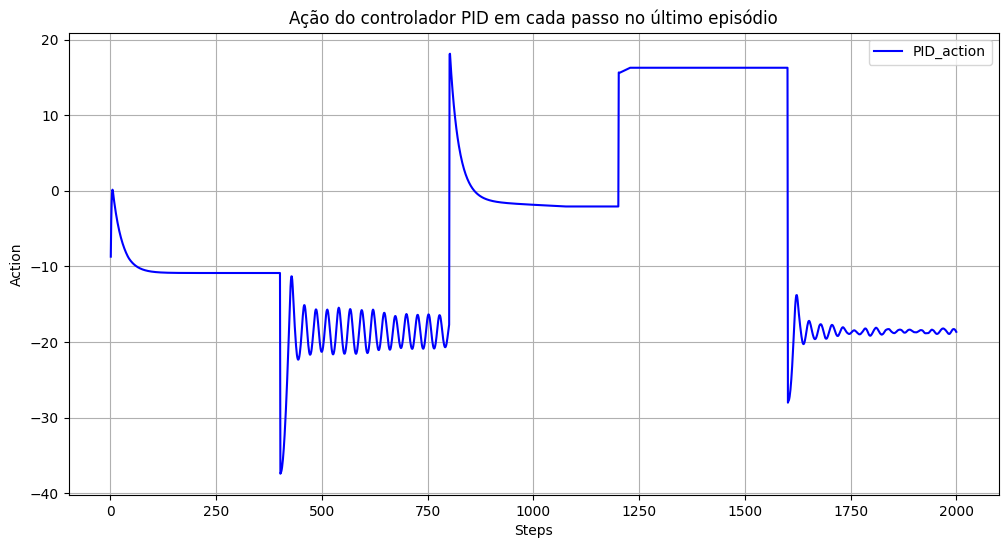

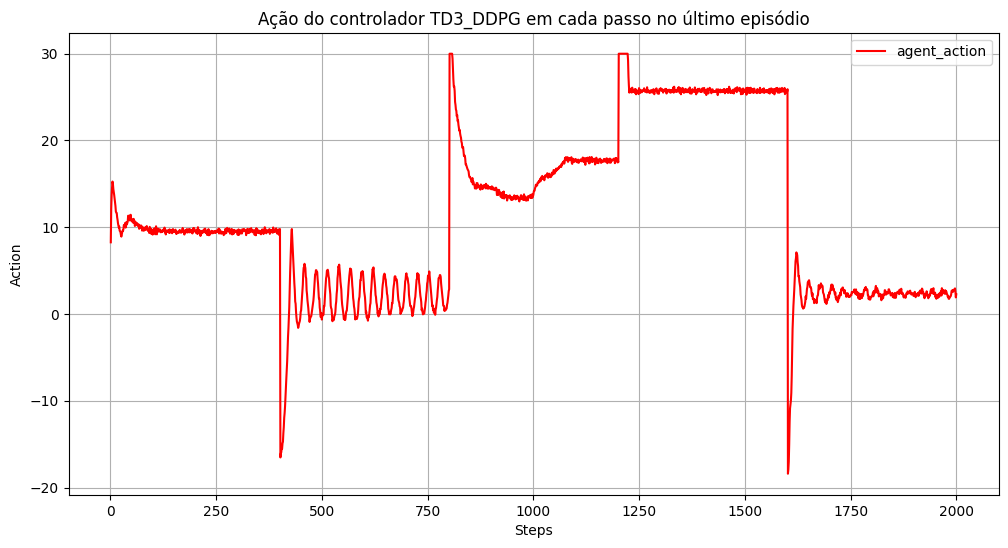

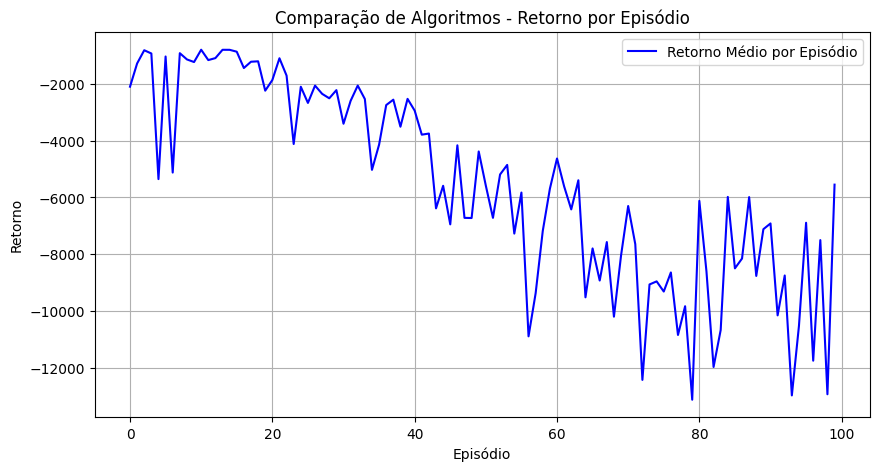

In [96]:
# Uncomment to use widget 
display_folders_grid(folder_names, selected_index)